This notebook has the plots to make the received sounds schematic.
Last updated October 2019.

In [1]:
import sys 
sys.path.append('../CPN/')
from the_cocktail_party_nightmare import *

In [2]:
import glob
import pickle
import dill
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np 
import pandas as pd

In [3]:
def load_simresult(path_to_simresult):
    '''
    '''
    with open(path_to_simresult, 'rb') as sim:
        output = dill.load(sim)
    return(output)

def gather_plot_data_from_sounddf(sounds):
    '''
    '''
    start, stop = sounds['start'], sounds['stop']    
    level = sounds['level']
    data_to_plot = np.column_stack((start, stop, level))
    return(data_to_plot)

def calculate_masker_SPL_profile(echo, **kwargs):
    '''
    '''
    apply_spatial_unmasking_on_sounds(float(echo['theta']), 
                                          kwargs['other_sounds'], **kwargs)
    cumulative_spl = ipi_soundpressure_levels(kwargs['other_sounds'], 'post_SUM',
                                                                  **kwargs)
    cumulative_dbspl = dB(cumulative_spl)
    return(cumulative_spl, cumulative_dbspl)

In [4]:
%matplotlib notebook

In [5]:
data_stores_in_folder = glob.glob('groupsize*.h5')
datastores_by_index = pd.DataFrame(data={'data_stores':data_stores_in_folder})
print(datastores_by_index)
# user-inputs dataset choice:
which_dataset = 3#int(raw_input('Give the index of the dataset you want to'))
# load a pre-exisiting dataset
#load the saved data 
data_load = pd.HDFStore(data_stores_in_folder[-1])
simulation_data = data_load['simulation_data']
data_load.close()

                           data_stores
0    groupsize_data[2019, 9, 23, 8].h5
1   groupsize_data[2019, 9, 26, 15].h5
2   groupsize_data[2019, 9, 23, 11].h5
3  groupsize_data[2019, 10, 14, 14].h5
4   groupsize_data[2019, 9, 27, 12].h5


In [188]:
np.random.seed(82319)
# choose a group size of 5 bats because it is easy to visualise the concept at a small group size:

group_size = 10
#which_index = int(np.random.choice(simulation_data[simulation_data['group_size']==group_size].index,1))
which_index = simulation_data[simulation_data['group_size']==group_size].index[0]
one_uuid = simulation_data[simulation_data['group_size']==group_size]['uuid'][which_index]
print(one_uuid)

# find the results file with this uuid
results_folder = '../simulations/effect_of_group_size/'
result_file = glob.glob(results_folder+'*'+one_uuid+'*')
print(result_file)

simresult = load_simresult(result_file[0])

sim_id, sim_data = simresult

nbrs_heard, received_sounds, group_geometry = sim_data

echoes_data = gather_plot_data_from_sounddf(received_sounds['target_echoes'])
calls_data = gather_plot_data_from_sounddf(received_sounds['conspecific_calls'])
seconadry_echoes = gather_plot_data_from_sounddf(received_sounds['2dary_echoes'])

other_sounds = combine_sounds([received_sounds['conspecific_calls'], received_sounds['2dary_echoes']])

temporal_masking_file  = '../data/temporal_masking_function.pkl'
with open(temporal_masking_file,'rb') as temp_masking:
    temporal_masking_thresholds = pickle.load(temp_masking)
    
# the masking curves - calculated fro 10**-6 temporal resolution
forward, simultaneous, backward = temporal_masking_thresholds


# spatial unmasking:
spatial_unmasking = pd.read_csv('../data/spatial_release_fn.csv')

keyword_arguments = {'interpulse_interval':0.1, 'simtime_resolution':10**-6,
                    'spatial_release_fn':np.array(spatial_unmasking)[:,1:],
                    'other_sounds':other_sounds}

c6ccf741-2ddf-41e0-898e-9d9305463bf9
['../simulations/effect_of_group_size/effect_of_groupsize_c6ccf741-2ddf-41e0-898e-9d9305463bf9_603833573_.simresults']


In [189]:
last_echo = received_sounds['target_echoes'].shape[0] -1 
one_echo = received_sounds['target_echoes'].loc[last_echo,:]
print(received_sounds['target_echoes'].loc[0,:])
masker_spl , masker_dbspl = calculate_masker_SPL_profile(one_echo, **keyword_arguments)

# just set the lowest sound pressure level to 0 - replace -inf
all_inf = np.isinf(masker_dbspl)
masker_dbspl[all_inf] = 0
echo_masker_profile = one_echo['level'] - masker_dbspl

R_incoming                   0.501023
R_outgoing                   0.501023
route                       (0, 1, 0)
sourcelevel_ref_distance            1
theta                          94.432
theta_emission                 94.432
theta_incoming                -98.568
theta_outgoing                -98.568
emitted_SPL                   92.4591
incoming_SPL                  98.4619
reflection_strength          -34.2765
level                         68.0337
start                             537
stop                             3036
Name: 0, dtype: object


<IPython.core.display.Javascript object>


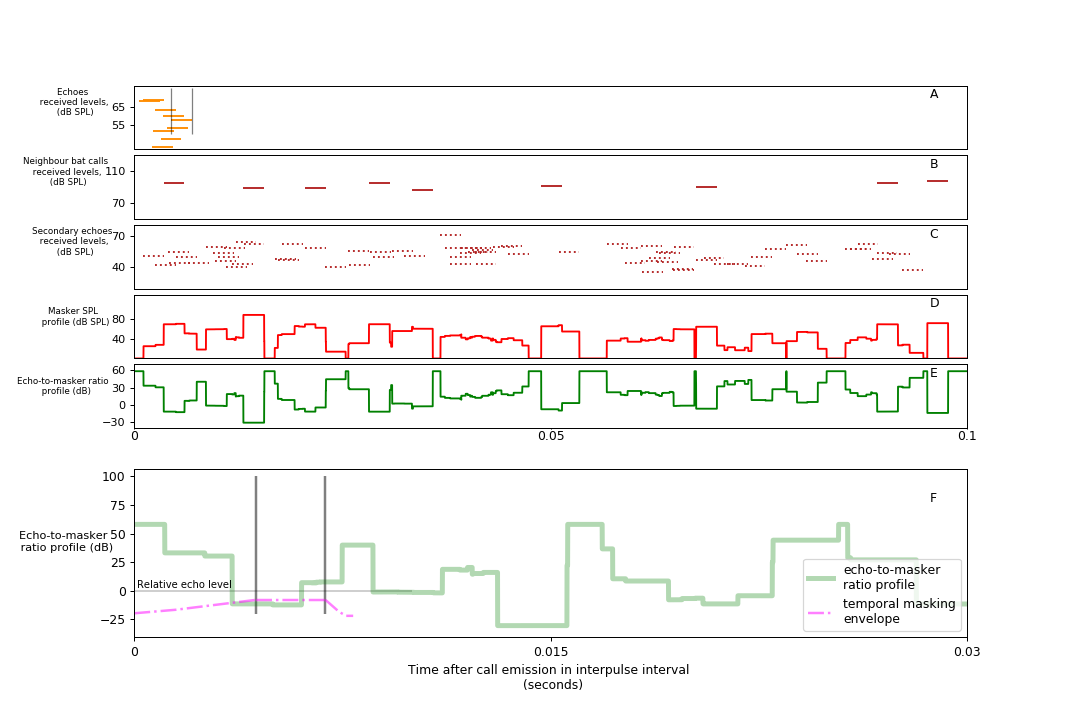

In [210]:
relative_x, relative_y = 0.955, 0.8

ylabel_fontsize = 7
ylabel_rotate = 0
ytick_fontsize = 9
ylabel_pad = 30

f = plt.figure(figsize=(12,8))

gs = GridSpec(16, 1)
# echoes plot
echoesplot = f.add_subplot(gs[:2])
plt.xticks([])
plt.hlines(echoes_data[:,-1],echoes_data[:,0],echoes_data[:,1],color='darkorange')
plt.xlim(0,-1+10**5)
plt.vlines([one_echo['start'],one_echo['stop']],50,75, linewidth=1,alpha=0.5)
plt.yticks([55,65], fontsize=ytick_fontsize)
echoesplot.text(relative_x, relative_y, 'A', fontsize=10,
                   transform=echoesplot.transAxes)
plt.ylabel('Echoes \n received levels, \n (dB SPL)', fontsize=ylabel_fontsize,
          rotation=ylabel_rotate, labelpad=ylabel_pad)

#plt.ylim(50,75)

# neighbouring bat calls plot
batcallsplot = f.add_subplot(gs[2:4])
plt.xticks([])
plt.hlines(calls_data[:,-1],calls_data[:,0],calls_data[:,1],color='firebrick')
plt.xlim(0,-1+10**5)
plt.ylim(50,130);plt.yticks([70,110], fontsize=ytick_fontsize)
batcallsplot.text(relative_x, relative_y, 'B', fontsize=10,
                   transform=batcallsplot.transAxes)
plt.ylabel('Neighbour bat calls \n received levels, \n (dB SPL)', fontsize=ylabel_fontsize,
          rotation=ylabel_rotate, labelpad=ylabel_pad)
# secondary echoes plot
secondaryecho = f.add_subplot(gs[4:6])
plt.xticks([])
plt.hlines(seconadry_echoes[:,-1],seconadry_echoes[:,0],seconadry_echoes[:,1],
                         linestyle=':', color='firebrick')
plt.xlim(0,-1+10**5)
plt.ylim(20,80);plt.yticks([40,70], fontsize=ytick_fontsize)
secondaryecho.text(relative_x, relative_y, 'C', fontsize=10,
                   transform=secondaryecho.transAxes)
plt.ylabel('Secondary echoes \n received levels, \n (dB SPL)', fontsize=ylabel_fontsize,
          rotation=ylabel_rotate, labelpad=ylabel_pad)

# masker SPL plot
maskerplot = f.add_subplot(gs[6:8])
#mock_spl_profile = np.random.choice(np.arange(50,70),100000)
plt.plot(np.arange(10**5),masker_dbspl, 'r-')
plt.xticks([])
plt.yticks([40,80],fontsize=ytick_fontsize)
plt.xlim(0,-1+10**5)
maskerplot.text(relative_x, relative_y, 'D', fontsize=10, transform=maskerplot.transAxes)
plt.ylim(0,130)
plt.ylabel('Masker SPL \n profile (dB SPL)', fontsize=ylabel_fontsize,
          rotation=ylabel_rotate, labelpad=ylabel_pad)

# echo-masker SPL plot
echomasker = f.add_subplot(gs[8:10])
#mock_spl_profile = np.random.choice(np.arange(-30,-10),100000)
plt.plot(np.arange(10**5),echo_masker_profile, 'g-')
plt.xticks([0,0.5*10**5,10**5],[0,0.05,0.1])
plt.xlim(0,-1+10**5)
echomasker.tick_params(axis='x', pad=0.5,length=1)
plt.yticks([-30,0,30,60], fontsize=ytick_fontsize)
plt.ylim(-40,70)
echomasker.text(relative_x, relative_y, 'E', fontsize=10, transform=echomasker.transAxes)

plt.ylabel('Echo-to-masker ratio \n profile (dB)', fontsize=ylabel_fontsize,
          rotation=ylabel_rotate, labelpad=ylabel_pad)


# zoom-in of temporal masking envelope
masker_profile_snippet = echo_masker_profile[:3*10**4] # take a 10ms snippet
fwd_masking_time = np.arange(one_echo['start']-forward.size,one_echo['start'])
bkwd_masking_time = np.arange(one_echo['stop'],one_echo['stop']+backward.size)
simultaneous_masking_time = np.arange(one_echo['start'],one_echo['stop'])

zoomin = f.add_subplot(gs[11:,:])
te_fontsize = 6 # temporal envelope fontsize

plt.plot(np.arange(masker_profile_snippet.size),
         masker_profile_snippet, 'g-', label='echo-to-masker\nratio profile',linewidth=4,alpha=0.3)

plt.plot(fwd_masking_time, forward,
        '-.',linewidth=2, alpha=0.5,color='fuchsia',) # forward masking

#plt.text(fwd_masking_time[-4000],forward[-4000]+4,'Forward masking', 
#         rotation=7, fontsize=te_fontsize)

plt.plot(bkwd_masking_time, backward,
        '-.',linewidth=2, color='fuchsia',alpha=0.5) # backward masking
#plt.text(bkwd_masking_time[300],backward[500]+8,'Backward \nmasking', rotation=-50,
#         fontsize=te_fontsize)


plt.plot(simultaneous_masking_time,
         np.tile(simultaneous, simultaneous_masking_time.size),
         '-.',color='fuchsia',label='temporal masking\nenvelope',linewidth=2, alpha=0.5) # simultaneous masking
#plt.text(one_echo['start']+10,simultaneous+1.8,'Simultaneous \nmasking',
#         fontsize=te_fontsize)


plt.hlines(0,0,10**4, linestyle='-',alpha=0.2); 
plt.text(0.01*10**4,2,'Relative echo level',
                                                fontsize=te_fontsize+2)

plt.vlines([one_echo['start'],one_echo['stop']],-20,100, linewidth=2,alpha=0.5)
plt.ylabel('Echo-to-masker \n ratio profile (dB)', fontsize=9,rotation=0, labelpad=28)
#plt.ylim(-30,10)
plt.xlim(0,one_echo['stop']+2*10**4)
plt.xticks([0,1.5*10**4,3*10**4],
           [0,0.015,0.03])
plt.xlabel('Time after call emission in interpulse interval \n (seconds)')
zoomin.text(relative_x, relative_y, 'F', fontsize=10, transform=zoomin.transAxes)
plt.legend(loc=4)
plt.savefig('sounds_in_ipi_schematic.png', bbox_inches='tight', pad_inches=0,dpi=300)


In [192]:
print(one_uuid)


c6ccf741-2ddf-41e0-898e-9d9305463bf9


In [193]:
10**5

100000

In [194]:
0.1/10**-6

100000.00000000001

<IPython.core.display.Javascript object>


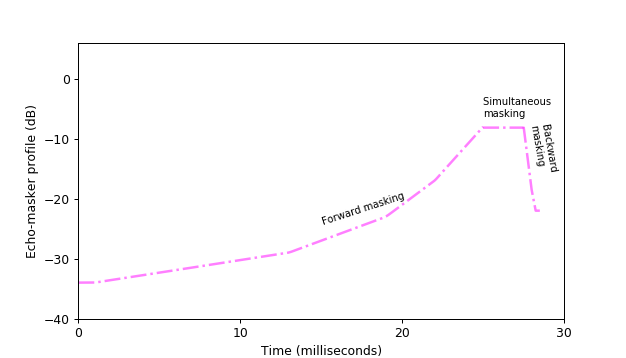

Text(0.5,0,'Time (milliseconds)')

In [195]:
f2 = plt.figure(figsize=(7,4))
# zoom-in of temporal masking envelope
masker_profile_snippet = echo_masker_profile[:10**4] # take a 10ms snippet
fwd_masking_time = np.arange(forward.size)
echo_timesteps = one_echo['stop']-one_echo['start']+1
simultaneous_masking_time = np.arange(fwd_masking_time[-1],fwd_masking_time[-1]+echo_timesteps)

bkwd_masking_time = np.arange(simultaneous_masking_time[-1], 
                              simultaneous_masking_time[-1]+backward.size)

te_fontsize = 8 # temporal envelope fontsize

plt.plot(fwd_masking_time, forward,
        '-.',linewidth=2, alpha=0.5,color='fuchsia',) # forward masking

plt.text(fwd_masking_time[-10000],forward[-10000]+7,'Forward masking', 
         rotation=18, fontsize=te_fontsize)

plt.plot(bkwd_masking_time, backward,
        '-.',linewidth=2, color='fuchsia',alpha=0.5) # backward masking
plt.text(bkwd_masking_time[300],backward[500]+8,'Backward \nmasking', rotation=-80,
         fontsize=te_fontsize)


plt.plot(simultaneous_masking_time,
         np.tile(simultaneous, simultaneous_masking_time.size),
         '-.',color='fuchsia',linewidth=2, alpha=0.5) # simultaneous masking
plt.text(simultaneous_masking_time[0],simultaneous+1.8,'Simultaneous \nmasking',
         fontsize=te_fontsize)
plt.ylim(-40,6)
plt.xlim(0,3*10**4)
plt.xticks(np.array([0,1,2,3])*10**4,np.arange(0,40,10))
plt.ylabel('Echo-masker profile (dB)')
plt.xlabel('Time (milliseconds)')
#plt.savefig('temporal_masking_fn.png', dpi=600)

In [223]:
one_number = 257
another_number = 257

if one_number is another_number:
    print('They are equal')
else:
    print('they are not equal')

they are not equal
